# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups        
Sample_149  A0A0A0MQY7;Q5VU97        16.924
Sample_090  B7Z4G8;F5GZ08;P51693     21.721
Sample_098  Q9UBG0                   15.650
Sample_150  B4E3Q4;Q9NZK5            14.445
Sample_129  P80188;P80188-2;X6R8F3   15.082
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups                                           
Sample_074  A0A1W2PP80;C9JGI3;P19971;P19971-2                           14.821
Sample_157  A0A0G2JLL6;A0A1B0GTE9;A0A1B0GTP1;Q7Z6L0;Q7Z6L0-2;Q7Z6L0-3   15.323
Sample_148  P26038                                                      15.627
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.052
            A0A075B6Q5                 12.273
            A0A075B6R2                 12.421
            A0A075B6S5                 13.466
            A0A087WSY4                 12.732
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   11.578
            Q9UI40;Q9UI40-2            13.418
            Q9UIW2                     12.476
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.991
            Q9UP79                     13.327
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.852,15.050,16.842,19.863,15.878,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.695,19.067,...,15.528,15.576,13.936,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.842,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.249,17.705,17.039,15.947,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.406,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.290,15.345,17.084,18.708,14.249,19.433,11.378,11.310
Sample_207,15.739,16.877,15.469,16.898,15.223,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,12.052,...,16.012,15.178,13.863,15.050,16.842,19.863,13.050,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.950,19.067,16.188,...,15.528,15.576,12.754,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.012,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,12.919,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,11.758,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.896,15.345,17.084,18.708,14.249,19.433,13.065,13.373
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 443.28it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.30it/s]

100%|██████████| 2/2 [00:00<00:00,  5.28it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.45it/s]

100%|██████████| 3/3 [00:00<00:00,  2.93it/s]

100%|██████████| 3/3 [00:00<00:00,  3.13it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.11it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.48it/s]

100%|██████████| 4/4 [00:00<00:00,  3.83it/s]

100%|██████████| 4/4 [00:00<00:00,  4.16it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.98it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.78it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.99it/s]

100%|██████████| 5/5 [00:01<00:00,  2.97it/s]

100%|██████████| 5/5 [00:01<00:00,  3.54it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.78it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.31it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.42it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.61it/s]

100%|██████████| 6/6 [00:02<00:00,  2.18it/s]

100%|██████████| 6/6 [00:02<00:00,  2.69it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.42it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.49it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.18it/s]

 71%|███████▏  | 5/7 [00:02<00:00,  2.26it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.38it/s]

100%|██████████| 7/7 [00:02<00:00,  2.57it/s]

100%|██████████| 7/7 [00:02<00:00,  2.49it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.72it/s]

 38%|███▊      | 3/8 [00:00<00:01,  2.75it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.40it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.27it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.30it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.41it/s]

100%|██████████| 8/8 [00:03<00:00,  2.48it/s]

100%|██████████| 8/8 [00:03<00:00,  2.53it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.43it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.42it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.96it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.49it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.34it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.24it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.48it/s]

100%|██████████| 9/9 [00:03<00:00,  2.58it/s]

100%|██████████| 9/9 [00:03<00:00,  2.71it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.62it/s]

 30%|███       | 3/10 [00:00<00:01,  4.68it/s]

 40%|████      | 4/10 [00:00<00:01,  4.30it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.91it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.98it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.62it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.26it/s]

 90%|█████████ | 9/10 [00:03<00:00,  1.94it/s]

100%|██████████| 10/10 [00:03<00:00,  1.86it/s]

100%|██████████| 10/10 [00:03<00:00,  2.51it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.96it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.40it/s]

 36%|███▋      | 4/11 [00:00<00:01,  3.84it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.82it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.55it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.60it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.47it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.60it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.65it/s]

100%|██████████| 11/11 [00:03<00:00,  2.53it/s]

100%|██████████| 11/11 [00:03<00:00,  2.80it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.15it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.15it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.88it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.78it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.71it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.86it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.95it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.89it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.88it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.89it/s]

100%|██████████| 12/12 [00:04<00:00,  2.95it/s]

100%|██████████| 12/12 [00:04<00:00,  2.94it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  3.79it/s]

 23%|██▎       | 3/13 [00:00<00:03,  2.87it/s]

 31%|███       | 4/13 [00:01<00:03,  2.66it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.45it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.58it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.55it/s]

 62%|██████▏   | 8/13 [00:03<00:01,  2.54it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.59it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.57it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.76it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.95it/s]

100%|██████████| 13/13 [00:04<00:00,  2.89it/s]

100%|██████████| 13/13 [00:04<00:00,  2.74it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.98it/s]

 21%|██▏       | 3/14 [00:01<00:03,  2.82it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.79it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.61it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.51it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.54it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.48it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.53it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.66it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.62it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.61it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.62it/s]

100%|██████████| 14/14 [00:05<00:00,  2.81it/s]

100%|██████████| 14/14 [00:05<00:00,  2.69it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.36it/s]

 20%|██        | 3/15 [00:00<00:03,  3.88it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.35it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.17it/s]

 40%|████      | 6/15 [00:01<00:02,  3.08it/s]

 47%|████▋     | 7/15 [00:02<00:02,  3.07it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.05it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.80it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.91it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.05it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.16it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.05it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.07it/s]

100%|██████████| 15/15 [00:04<00:00,  3.05it/s]

100%|██████████| 15/15 [00:04<00:00,  3.14it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.000      0.048 0.008          0.731 0.364       0.117   
2             0.004 0.000      0.050 0.015          0.635 0.141       0.460   
3             0.005 0.004      0.056 0.016          0.818 0.075       0.706   
4             0.005 0.003      0.060 0.020          0.810 0.085       0.763   
5             0.007 0.006      0.086 0.019          0.823 0.084       0.773   
6             0.004 0.002      0.054 0.017          0.820 0.084       0.772   
7             0.004 0.002      0.055 0.017          0.814 0.088       0.770   
8             0.006 0.005      0.073 0.028          0.810 0.084       0.835   
9             0.006 0.005      0.073 0.029          0.814 0.088       0.829   
10            0.004 0.002      0.063 0.025          0.817 0.085       0.827   
11            0.005 0.005      0.062 0.026          0.822 0.084       0.861   
12            0.006 0.004      0.061 0.020          0.829 0.079       0.859   
13            0.005 0.004      0.061 0.027          0.815 0.078       0.859   
14            0.005 0.003      0.061 0.022          0.836 0.085       0.824   
15            0.006 0.004      0.070 0.024          0.825 0.082       0.822   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.087   0.194 0.133                  0.551 0.042        0.855   
2          0.114   0.523 0.100                  0.627 0.068        0.703   
3          0.100   0.753 0.068                  0.794 0.053        0.898   
4          0.103   0.780 0.068                  0.814 0.057        0.909   
5          0.102   0.793 0.072                  0.824 0.061        0.914   
6          0.101   0.791 0.071                  0.822 0.060        0.912   
7          0.122   0.785 0.084                  0.819 0.068        0.912   
8          0.102   0.818 0.072                  0.844 0.062        0.923   
9          0.105   0.817 0.074                  0.843 0.063        0.920   
10         0.107   0.817 0.074                  0.844 0.063        0.921   
11         0.101   0.837 0.073                  0.861 0.063        0.925   
12         0.100   0.840 0.070                  0.863 0.060        0.924   
13         0.099   0.834 0.071                  0.858 0.061        0.921   
14         0.105   0.826 0.076                  0.851 0.064        0.929   
15         0.103   0.819 0.074                  0.846 0.062        0.928   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.068                  0.827 0.092        210.000 0.000  
2          0.084                  0.654 0.100        210.000 0.000  
3          0.046                  0.876 0.058        210.000 0.000  
4          0.043                  0.885 0.053        210.000 0.000  
5          0.045                  0.894 0.055        210.000 0.000  
6          0.047                  0.892 0.057        210.000 0.000  
7          0.049                  0.892 0.060        210.000 0.000  
8          0.044                  0.909 0.049        210.000 0.000  
9          0.045                  0.904 0.052        210.000 0.000  
10         0.046                  0.905 0.053        210.000 0.000  
11         0.043                  0.909 0.049        210.000 0.000  
12         0.043                  0.908 0.050        210.000 0.000  
13         0.044                  0.906 0.050        210.000 0.000  
14         0.041                  0.915 0.048        210.000 0.000  
15         0.039                  0.915 0.046 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 458.14it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.96it/s]

100%|██████████| 2/2 [00:00<00:00,  4.92it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.59it/s]

100%|██████████| 3/3 [00:00<00:00,  4.04it/s]

100%|██████████| 3/3 [00:00<00:00,  4.26it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.02it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.11it/s]

100%|██████████| 4/4 [00:01<00:00,  2.92it/s]

100%|██████████| 4/4 [00:01<00:00,  3.08it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.53it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.46it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.47it/s]

100%|██████████| 5/5 [00:01<00:00,  2.62it/s]

100%|██████████| 5/5 [00:01<00:00,  2.65it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.66it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.51it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.00it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.93it/s]

100%|██████████| 6/6 [00:01<00:00,  2.93it/s]

100%|██████████| 6/6 [00:01<00:00,  3.11it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.94it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.94it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.46it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.22it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.99it/s]

100%|██████████| 7/7 [00:02<00:00,  2.88it/s]

100%|██████████| 7/7 [00:02<00:00,  3.22it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.99it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.58it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.98it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.32it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.12it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  1.97it/s]

100%|██████████| 8/8 [00:03<00:00,  2.08it/s]

100%|██████████| 8/8 [00:03<00:00,  2.36it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  3.88it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.52it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.34it/s]

 56%|█████▌    | 5/9 [00:02<00:01,  2.36it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.35it/s]

 78%|███████▊  | 7/9 [00:03<00:00,  2.01it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  1.88it/s]

100%|██████████| 9/9 [00:04<00:00,  1.76it/s]

100%|██████████| 9/9 [00:04<00:00,  2.07it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:02,  3.42it/s]

 30%|███       | 3/10 [00:01<00:02,  2.61it/s]

 40%|████      | 4/10 [00:01<00:02,  2.57it/s]

 50%|█████     | 5/10 [00:01<00:02,  2.40it/s]

 60%|██████    | 6/10 [00:02<00:02,  1.90it/s]

 70%|███████   | 7/10 [00:03<00:01,  1.77it/s]

 80%|████████  | 8/10 [00:03<00:01,  1.79it/s]

 90%|█████████ | 9/10 [00:04<00:00,  1.93it/s]

100%|██████████| 10/10 [00:04<00:00,  2.06it/s]

100%|██████████| 10/10 [00:04<00:00,  2.11it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.94it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.28it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.05it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.70it/s]

 55%|█████▍    | 6/11 [00:02<00:01,  2.64it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.73it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.80it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.85it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.86it/s]

100%|██████████| 11/11 [00:03<00:00,  2.91it/s]

100%|██████████| 11/11 [00:03<00:00,  2.93it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.80it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.58it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.00it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.82it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.78it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.81it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.78it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.71it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.63it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.74it/s]

100%|██████████| 12/12 [00:04<00:00,  2.90it/s]

100%|██████████| 12/12 [00:04<00:00,  2.92it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.41it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.83it/s]

 31%|███       | 4/13 [00:01<00:02,  3.45it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.21it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.90it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.95it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.90it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.91it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.87it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.33it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.13it/s]

100%|██████████| 13/13 [00:04<00:00,  1.99it/s]

100%|██████████| 13/13 [00:04<00:00,  2.61it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.98it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.26it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.76it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.23it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.12it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.11it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.95it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.51it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.25it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.13it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.18it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.28it/s]

100%|██████████| 14/14 [00:05<00:00,  2.29it/s]

100%|██████████| 14/14 [00:05<00:00,  2.65it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.78it/s]

 20%|██        | 3/15 [00:00<00:02,  4.02it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.52it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.20it/s]

 40%|████      | 6/15 [00:01<00:02,  3.11it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.54it/s]

 53%|█████▎    | 8/15 [00:02<00:03,  2.21it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.19it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.18it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.21it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.35it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.38it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.39it/s]

100%|██████████| 15/15 [00:05<00:00,  2.46it/s]

100%|██████████| 15/15 [00:05<00:00,  2.58it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.000      0.047 0.002          0.013 0.094       0.002   
2             0.005 0.004      0.060 0.021          0.772 0.119       0.633   
3             0.005 0.003      0.066 0.023          0.763 0.093       0.686   
4             0.005 0.003      0.052 0.014          0.760 0.096       0.684   
5             0.004 0.000      0.048 0.008          0.749 0.096       0.668   
6             0.004 0.002      0.059 0.025          0.744 0.096       0.677   
7             0.006 0.005      0.068 0.030          0.740 0.109       0.695   
8             0.005 0.003      0.052 0.011          0.743 0.107       0.697   
9             0.005 0.003      0.052 0.013          0.761 0.099       0.734   
10            0.004 0.002      0.060 0.031          0.787 0.085       0.788   
11            0.005 0.005      0.059 0.021          0.790 0.085       0.795   
12            0.005 0.004      0.070 0.024          0.791 0.090       0.796   
13            0.005 0.005      0.057 0.020          0.789 0.091       0.794   
14            0.005 0.003      0.056 0.018          0.787 0.090       0.792   
15            0.005 0.002      0.054 0.015          0.794 0.085       0.790   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.017   0.004 0.028                  0.497 0.010        0.860   
2          0.125   0.687 0.096                  0.744 0.073        0.788   
3          0.116   0.717 0.087                  0.764 0.067        0.852   
4          0.117   0.714 0.088                  0.762 0.068        0.850   
5          0.128   0.699 0.091                  0.750 0.071        0.868   
6          0.131   0.702 0.094                  0.752 0.073        0.868   
7          0.133   0.711 0.104                  0.757 0.084        0.873   
8          0.129   0.714 0.100                  0.759 0.081        0.871   
9          0.120   0.744 0.095                  0.782 0.079        0.882   
10         0.112   0.783 0.080                  0.816 0.067        0.908   
11         0.112   0.788 0.080                  0.819 0.067        0.911   
12         0.112   0.788 0.082                  0.819 0.069        0.913   
13         0.112   0.787 0.081                  0.818 0.069        0.911   
14         0.115   0.784 0.082                  0.816 0.069        0.911   
15         0.108   0.788 0.079                  0.819 0.066        0.915   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.828 0.089        210.000 0.000  
2          0.076                  0.732 0.095        210.000 0.000  
3          0.060                  0.820 0.074        210.000 0.000  
4          0.062                  0.817 0.073        210.000 0.000  
5          0.057                  0.839 0.067        210.000 0.000  
6          0.057                  0.839 0.066        210.000 0.000  
7          0.059                  0.846 0.069        210.000 0.000  
8          0.061                  0.843 0.069        210.000 0.000  
9          0.059                  0.861 0.065        210.000 0.000  
10         0.050                  0.886 0.058        210.000 0.000  
11         0.049                  0.887 0.058        210.000 0.000  
12         0.048                  0.891 0.056        210.000 0.000  
13         0.048                  0.889 0.056        210.000 0.000  
14         0.048                  0.890 0.056        210.000 0.000  
15         0.046                  0.896 0.055 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 968.66it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 22.54it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 16.63it/s]

100%|██████████| 3/3 [00:00<00:00, 13.16it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 18.08it/s]

100%|██████████| 4/4 [00:00<00:00, 15.66it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 15.36it/s]

 80%|████████  | 4/5 [00:00<00:00, 12.73it/s]

100%|██████████| 5/5 [00:00<00:00, 12.97it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 19.18it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 15.69it/s]

100%|██████████| 6/6 [00:00<00:00, 16.06it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 18.72it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 15.32it/s]

100%|██████████| 7/7 [00:00<00:00, 13.49it/s]

100%|██████████| 7/7 [00:00<00:00, 14.22it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 23.20it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 18.60it/s]

100%|██████████| 8/8 [00:00<00:00, 17.61it/s]

100%|██████████| 8/8 [00:00<00:00, 18.24it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 29.19it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 22.36it/s]

100%|██████████| 9/9 [00:00<00:00, 20.11it/s]

100%|██████████| 9/9 [00:00<00:00, 21.03it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 22.77it/s]

 60%|██████    | 6/10 [00:00<00:00, 18.61it/s]

 80%|████████  | 8/10 [00:00<00:00, 17.26it/s]

100%|██████████| 10/10 [00:00<00:00, 16.94it/s]

100%|██████████| 10/10 [00:00<00:00, 17.62it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 26.70it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 21.94it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 21.85it/s]

100%|██████████| 11/11 [00:00<00:00, 22.19it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 33%|███▎      | 4/12 [00:00<00:00, 28.01it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 24.49it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 23.63it/s]

100%|██████████| 12/12 [00:00<00:00, 24.11it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 31%|███       | 4/13 [00:00<00:00, 28.94it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 22.05it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 17.73it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 18.17it/s]

100%|██████████| 13/13 [00:00<00:00, 19.16it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 19.13it/s]

 43%|████▎     | 6/14 [00:00<00:00, 19.62it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 18.96it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 19.11it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 20.09it/s]

100%|██████████| 14/14 [00:00<00:00, 20.00it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 26.29it/s]

 40%|████      | 6/15 [00:00<00:00, 20.78it/s]

 60%|██████    | 9/15 [00:00<00:00, 20.75it/s]

 80%|████████  | 12/15 [00:00<00:00, 21.52it/s]

100%|██████████| 15/15 [00:00<00:00, 21.76it/s]

100%|██████████| 15/15 [00:00<00:00, 21.68it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.055 0.023          0.000 0.000       0.000   
2             0.004 0.001      0.052 0.014          0.609 0.115       0.438   
3             0.004 0.001      0.047 0.013          0.612 0.118       0.430   
4             0.006 0.004      0.070 0.026          0.633 0.110       0.473   
5             0.004 0.003      0.051 0.016          0.651 0.108       0.513   
6             0.004 0.004      0.046 0.012          0.655 0.110       0.510   
7             0.004 0.000      0.047 0.004          0.650 0.112       0.509   
8             0.003 0.002      0.035 0.012          0.645 0.111       0.503   
9             0.003 0.004      0.032 0.009          0.687 0.103       0.582   
10            0.003 0.001      0.035 0.010          0.670 0.095       0.597   
11            0.003 0.001      0.030 0.006          0.661 0.098       0.590   
12            0.003 0.001      0.031 0.012          0.649 0.100       0.578   
13            0.002 0.000      0.028 0.003          0.649 0.092       0.588   
14            0.002 0.000      0.029 0.006          0.648 0.095       0.587   
15            0.003 0.001      0.030 0.007          0.657 0.094       0.591   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.759   
2          0.101   0.503 0.092                  0.614 0.060        0.716   
3          0.098   0.498 0.090                  0.612 0.059        0.712   
4          0.100   0.535 0.088                  0.634 0.061        0.708   
5          0.106   0.567 0.088                  0.653 0.065        0.723   
6          0.118   0.566 0.097                  0.654 0.069        0.725   
7          0.116   0.563 0.097                  0.652 0.068        0.721   
8          0.119   0.557 0.098                  0.648 0.068        0.717   
9          0.096   0.623 0.077                  0.690 0.060        0.760   
10         0.108   0.625 0.083                  0.688 0.063        0.774   
11         0.105   0.617 0.083                  0.681 0.064        0.783   
12         0.107   0.604 0.085                  0.671 0.065        0.777   
13         0.108   0.610 0.083                  0.675 0.062        0.777   
14         0.110   0.609 0.086                  0.674 0.064        0.773   
15         0.106   0.616 0.085                  0.680 0.065        0.782   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.068                  0.700 0.087        210.000 0.000  
2          0.076                  0.667 0.085        210.000 0.000  
3          0.076                  0.661 0.083        210.000 0.000  
4          0.076                  0.666 0.082        210.000 0.000  
5          0.078                  0.676 0.088        210.000 0.000  
6          0.076                  0.678 0.087        210.000 0.000  
7          0.075                  0.671 0.087        210.000 0.000  
8          0.077                  0.666 0.087        210.000 0.000  
9          0.072                  0.717 0.089        210.000 0.000  
10         0.071                  0.727 0.090        210.000 0.000  
11         0.060                  0.739 0.074        210.000 0.000  
12         0.062                  0.735 0.077        210.000 0.000  
13         0.064                  0.737 0.077        210.000 0.000  
14         0.063                  0.728 0.077        210.000 0.000  
15         0.064                  0.732 0.080 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,5,7,4
score_time,5,12,4
test_precision,14,15,9
test_recall,11,12,10
test_f1,12,12,10
test_balanced_accuracy,12,12,9
test_roc_auc,14,15,11
test_average_precision,14,15,11
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  8.61it/s]

 20%|██        | 3/15 [00:00<00:01,  6.25it/s]

 27%|██▋       | 4/15 [00:00<00:02,  5.46it/s]

 33%|███▎      | 5/15 [00:00<00:01,  5.18it/s]

 40%|████      | 6/15 [00:01<00:02,  4.15it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.00it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.07it/s]

 60%|██████    | 9/15 [00:01<00:01,  4.14it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  4.25it/s]

 73%|███████▎  | 11/15 [00:02<00:00,  4.41it/s]

 80%|████████  | 12/15 [00:02<00:00,  4.45it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  4.50it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  4.47it/s]

100%|██████████| 15/15 [00:03<00:00,  4.52it/s]

100%|██████████| 15/15 [00:03<00:00,  4.59it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 36%|███▋      | 4/11 [00:00<00:00, 28.47it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 25.21it/s]

 91%|█████████ | 10/11 [00:00<00:00, 24.45it/s]

100%|██████████| 11/11 [00:00<00:00, 22.42it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01, 10.06it/s]

 29%|██▊       | 4/14 [00:00<00:01,  6.60it/s]

 36%|███▌      | 5/14 [00:00<00:01,  6.13it/s]

 43%|████▎     | 6/14 [00:00<00:01,  5.89it/s]

 50%|█████     | 7/14 [00:01<00:01,  5.49it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  5.41it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  5.39it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  5.39it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  5.19it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  4.44it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  4.55it/s]

100%|██████████| 14/14 [00:02<00:00,  4.59it/s]

100%|██████████| 14/14 [00:02<00:00,  5.27it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


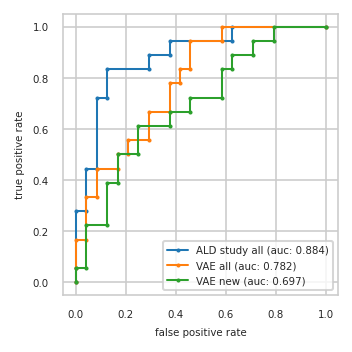

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.000 0.056
2          0.000 0.278   0.000 0.167   0.042 0.056
3          0.042 0.278   0.042 0.167   0.042 0.222
4          0.042 0.444   0.042 0.333   0.125 0.222
5          0.083 0.444   0.083 0.333   0.125 0.389
6          0.083 0.722   0.083 0.444   0.167 0.389
7          0.125 0.722   0.167 0.444   0.167 0.500
8          0.125 0.833   0.167 0.500   0.250 0.500
9          0.292 0.833   0.208 0.500   0.250 0.611
10         0.292 0.889   0.208 0.556   0.375 0.611
11         0.375 0.889   0.292 0.556   0.375 0.667
12         0.375 0.944   0.292 0.667   0.458 0.667
13         0.625 0.944   0.375 0.667   0.458 0.722
14         0.625 1.000   0.375 0.778   0.583 0.722
15         1.000 1.000   0.417 0.778   0.583 0.833
16           NaN   NaN   0.417 0.833   0.625 0.833
17           NaN   NaN   0.458 0.833   0.625 0.889
18           NaN   NaN   0.458 0.944   0.708 0.889
19           NaN   NaN   0.583 0.944   0.708 0.944
20           NaN   NaN   0.583 1.000   0.792 0.944
21           NaN   NaN   1.000 1.000   0.792 1.000
22           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,P09960;P09960-4,P08670,J3KSJ8;Q9UD71;Q9UD71-2
2,A0A075B6J9,P02766,P51688
3,P61981,F8WAD8;Q9P0K1;Q9P0K1-2;Q9P0K1-3;Q9P0K1-4;Q9P0K1-5,P31321
4,P04075,P61981,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
5,Q02818,Q9Y2T3;Q9Y2T3-3,Q96GD0
6,P14174,P04075,Q9NUQ9
7,Q9Y2T3;Q9Y2T3-3,Q14894,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
8,P00338;P00338-3,P14174,Q9Y281;Q9Y281-3


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


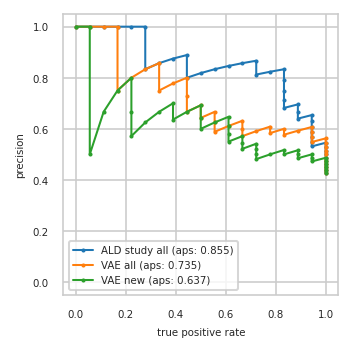

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.485 0.889
10         0.531 0.944     0.562 1.000     0.500 0.889
11         0.548 0.944     0.548 0.944     0.516 0.889
12         0.567 0.944     0.567 0.944     0.500 0.833
13         0.586 0.944     0.586 0.944     0.517 0.833
14         0.607 0.944     0.607 0.944     0.500 0.778
15         0.630 0.944     0.593 0.889     0.481 0.722
16         0.654 0.944     0.577 0.833     0.500 0.722
17         0.640 0.889     0.600 0.833     0.520 0.722
18         0.667 0.889     0.583 0.778     0.542 0.722
19         0.696 0.889     0.609 0.778     0.522 0.667
20         0.682 0.833     0.591 0.722     0.545 0.667
21         0.714 0.833     0.571 0.667     0.571 0.667
22         0.750 0.833     0.600 0.667     0.550 0.611
23         0.789 0.833     0.632 0.667     0.579 0.611
24         0.833 0.833     0.611 0.611     0.611 0.611
25         0.824 0.778     0.588 0.556     0.647 0.611
26         0.812 0.722     0.625 0.556     0.625 0.556
27         0.867 0.722     0.667 0.556     0.600 0.500
28         0.857 0.667     0.643 0.500     0.643 0.500
29         0.846 0.611     0.692 0.500     0.692 0.500
30         0.833 0.556     0.667 0.444     0.667 0.444
31         0.818 0.500     0.727 0.444     0.636 0.389
32         0.800 0.444     0.800 0.444     0.700 0.389
33         0.889 0.444     0.778 0.389     0.667 0.333
34         0.875 0.389     0.750 0.333     0.625 0.278
35         0.857 0.333     0.857 0.333     0.571 0.222
36         0.833 0.278     0.833 0.278     0.667 0.222
37         1.000 0.278     0.800 0.222     0.800 0.222
38         1.000 0.222     0.750 0.167     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


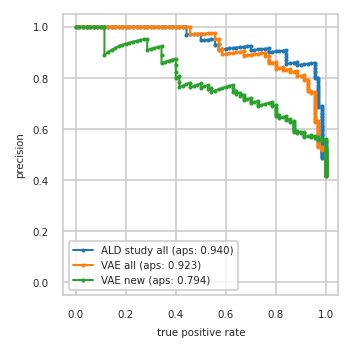

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


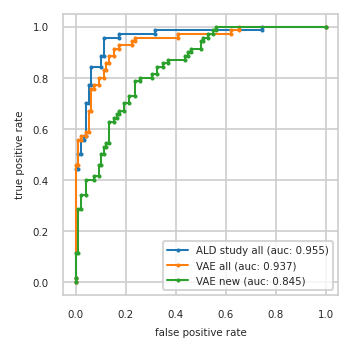

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}